In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages

In [3]:
import tensorflow as tf

cf = tf.ConfigProto()
cf.gpu_options.allow_growth = True
sess = tf.Session(config=cf)

In [10]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Tutorial
---

## Configurations

In [29]:
class CalcMassConfig(Config):
    """
    Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 2 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    IMAGE_CHANNEL_COUNT = 3
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 200

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = CalcMassConfig()
#config.display()

## Notebook Preferences

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [6]:
import json
import skimage
class CalcMassDataset(utils.Dataset):

    def load_full_mammo_img(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        
        self.add_class("AbnormalType", 1, "Calc")
        self.add_class("AbnormalType", 2, "Mass")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        print("path join : " ,dataset_dir)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "anno01.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "AbnormalType",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        info = self.image_info[image_id]
        shapes = info['id']
        #print(polygons)
        #print(len(polygons))
        #print(polygons[0]["name"])
        
        count = len(info["polygons"])
        #print(shapes)
        #print(count)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
            #print(p)
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_point_y'], p['all_point_x'])
            mask[rr, cc, i] = 1
            
        # Map class names to class IDs.
        #print('shapes',shapes)
        class_ids = np.array([self.class_names.index(info["polygons"][0]["name"])]*count)
        return mask.astype(np.bool), class_ids.astype(np.int32)

## Load dataset

In [6]:
# ROOT_DIR = r'D:\Gproject\DataSet\tcia_data'
# CALCMASS_DIR = os.path.join(ROOT_DIR, "dataset_dir")

# # Load validation dataset
# dataset = CalcMassDataset()
# dataset.load_full_mammo_img(CALCMASS_DIR, "train")

# # Must call before using the dataset
# dataset.prepare()

# print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 632
Classes: ['BG', 'Calc', 'Mass']


In [7]:
ROOT_DIR = r'D:\Gproject\DataSet\tcia_data'
CALCMASS_DIR = os.path.join(ROOT_DIR, "dataset_dir")

# Training dataset
dataset_train = CalcMassDataset()
dataset_train.load_full_mammo_img(CALCMASS_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CalcMassDataset()
dataset_val.load_full_mammo_img(CALCMASS_DIR, "val")
dataset_val.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_train.image_ids), dataset_train.class_names))
print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

path join :  D:\Gproject\DataSet\tcia_data\dataset_dir\train
path join :  D:\Gproject\DataSet\tcia_data\dataset_dir\val
Images: 2364
Classes: ['BG', 'Calc', 'Mass']
Images: 632
Classes: ['BG', 'Calc', 'Mass']


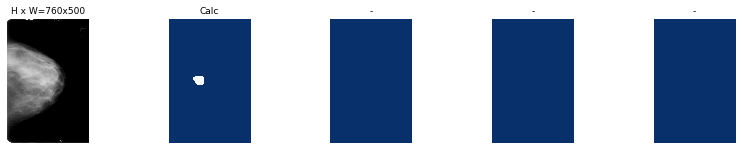

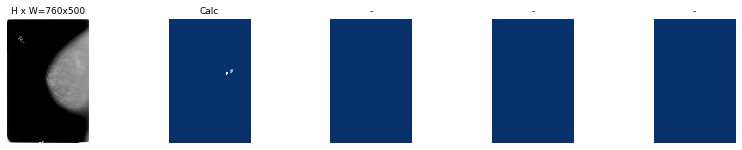

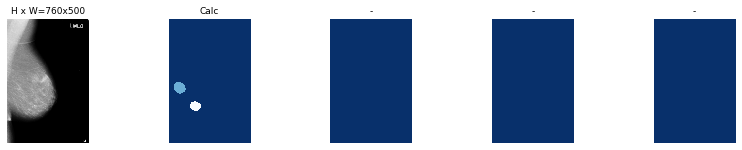

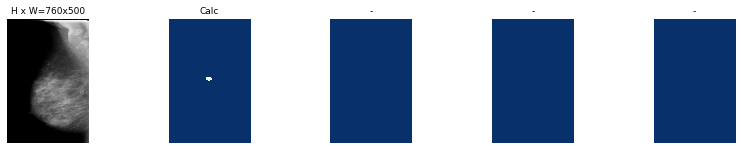

In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)

#4개의 랜덤이미지를 보여줌
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Create and Training model
---

In [10]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [11]:
# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [12]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
hist = model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: D:\Gproject\Codes\Mask_RCNN_1.14\logs\shapes20200519T1033\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)

C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "







Epoch 1/30
200/200 [==============================] - 132s 661ms/step - loss: 2.7629 - rpn_class_loss: 0.0702 - rpn_bbox_loss: 1.5729 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.6404 - mrcnn_mask_loss: 0.4475 - val_loss: 1.3319 - val_rpn_class_loss: 0.0417 - val_rpn_bbox_loss: 1.1587 - val_mrcnn_class_loss: 0.0318 - val_mrcnn_bbox_loss: 0.2998 - val_mrcnn_mask_loss: 0.4017
Epoch 2/30
200/200 [==============================] - 120s 602ms/step - loss: 2.6545 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 1.2395 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.7087 - mrcnn_mask_loss: 0.6182 - val_loss: 2.6956 - val_rpn_class_loss: 0.0408 - val_rpn_bbox_loss: 1.3379 - val_mrcnn_class_loss: 0.0667 - val_mrcnn_bbox_loss: 0.7007 - val_mrcnn_mask_loss: 0.6854
Epoch 3/30
200/200 [==============================] - 121s 606ms/step - loss: 2.4904 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 1.0978 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.6645 - mrcnn_mask_loss: 0.6278 - val_loss: 2.0666 - v

In [14]:
model.

NoneType

# Detection
---

In [15]:
class InferenceConfig(CalcMassConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  D:\Gproject\Codes\Mask_RCNN_1.14\logs\shapes20200519T1033\mask_rcnn_shapes_0030.h5
Re-starting from epoch 30


578
original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  760.00000  float64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:   95.00000  max:  142.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


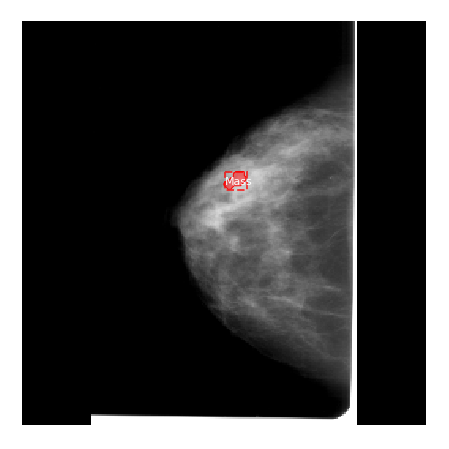

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


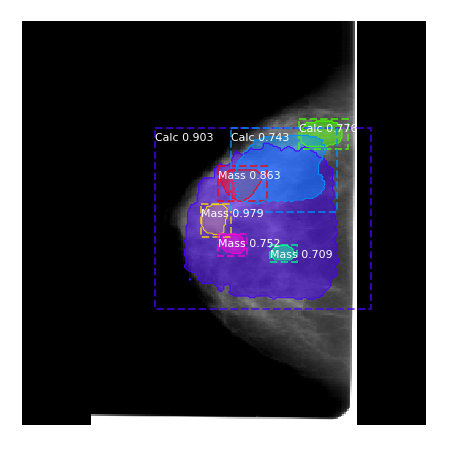

In [22]:
# Test on a random image
# well : 529
# 478
image_id = random.choice(dataset_val.image_ids)

print(image_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))


results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())


In [74]:
#bbox
r['rois'][0]

#r['masks'].shape
#순위
#r['scores']

array([ 75, 104, 186, 180])

In [44]:
r['scores']

array([0.80305284, 0.77944916, 0.76052433, 0.7571661 ], dtype=float32)

## Evaluation
---

In [24]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 100)
APs = []
precisions_list=[]
recalls_list=[]
overlaps_list=[]

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    precisions_list.append(precisions)
    recalls_list.append(recalls)
    overlaps_list.append(overlaps)
    
print("mAP: ", np.mean(APs))

mAP:  0.2931944444444444


# Tunning
---

# DataSet_ tunning
---


In [4]:
import json
import skimage
class CalcMassDataset(utils.Dataset):

    def load_full_mammo_img(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        
        self.add_class("AbnormalType", 1, "Calc")
        self.add_class("AbnormalType", 2, "Mass")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        print("path join : " ,dataset_dir)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "anno01.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path,as_gray=True)
            height, width = image.shape[:2]

            self.add_image(
                "AbnormalType",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)
    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        info = self.image_info[image_id]
        shapes = info['id']
        #print(polygons)
        #print(len(polygons))
        #print(polygons[0]["name"])
        
        count = len(info["polygons"])
        #print(shapes)
        #print(count)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
            #print(p)
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_point_y'], p['all_point_x'])
            mask[rr, cc, i] = 1
            
        # Map class names to class IDs.
        #print('shapes',shapes)
        class_ids = np.array([self.class_names.index(info["polygons"][0]["name"])]*count)
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [5]:
ROOT_DIR = r'D:\Gproject\DataSet\tcia_data'
CALCMASS_DIR = os.path.join(ROOT_DIR, "dataset_dir")

# Training dataset
dataset_train = CalcMassDataset()
dataset_train.load_full_mammo_img(CALCMASS_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = CalcMassDataset()
dataset_val.load_full_mammo_img(CALCMASS_DIR, "val")
dataset_val.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_train.image_ids), dataset_train.class_names))
print("Images: {}\nClasses: {}".format(len(dataset_val.image_ids), dataset_val.class_names))

path join :  D:\Gproject\DataSet\tcia_data\dataset_dir\train
path join :  D:\Gproject\DataSet\tcia_data\dataset_dir\val
Images: 2364
Classes: ['BG', 'Calc', 'Mass']
Images: 632
Classes: ['BG', 'Calc', 'Mass']


In [ ]:
# history = model.keras_model.history.history

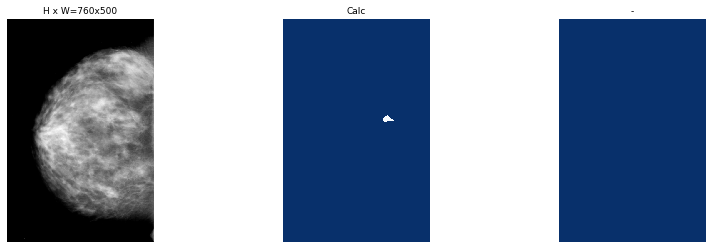

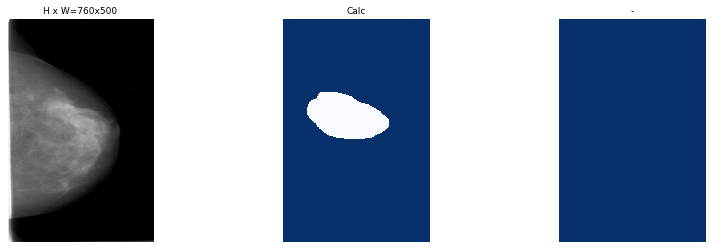

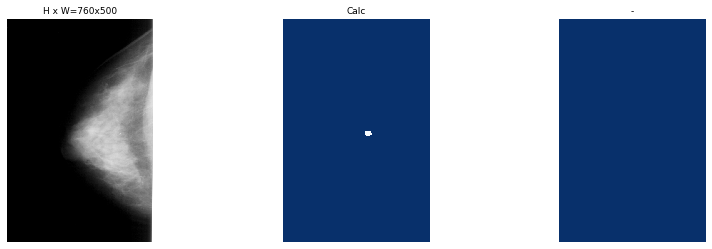

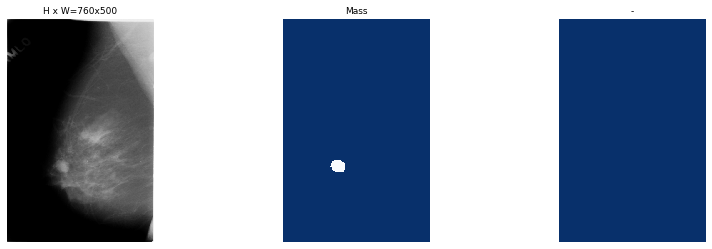

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)

#4개의 랜덤이미지를 보여줌
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names,limit=2)

In [89]:
image.shape

(760, 500, 3)

# Create & Tranning model_Tunning
---

In [7]:
class CalcMassConfig(Config):
    """
    Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 2 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    IMAGE_CHANNEL_COUNT = 3
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 200

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = CalcMassConfig()
#config.display()

In [9]:
# Create model in training mode
all_model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [9]:
# image augmentation
import imgaug
# set callback
from keras import callbacks
ct_callback = [callbacks.TensorBoard(log_dir=r"D:\Gproject\tensorboard_test")]

In [10]:
# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    all_model.load_weights(all_model.get_imagenet_weights(), by_name=True)

In [11]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
all_model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30,
            augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.Flipud(0.5)]),
            custom_callbacks= ct_callback,
            layers='5+')


Starting at epoch 0. LR=0.001

Checkpoint Path: D:\Gproject\Codes\Mask_RCNN_1.14\logs\shapes20200519T1818\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
res5a_branch2a         (Conv2D)
bn5a_branch2a          (BatchNorm)
res5a_branch2b         (Conv2D)
bn5a_branch2b          (BatchNorm)
res5a_branch2c         (Conv2D)
res5a_branch1          (Conv2D)
bn5a_branch2c          (BatchNorm)
bn5a_branch1           (BatchNorm)
res5b_branch2a         (Conv2D)
bn5b_branch2a          (BatchNorm)
res5b_branch2b         (Conv2D)
bn5b_branch2b          (BatchNorm)
res5b_branch2c         (Conv2D)
bn5b_branch2c          (BatchNorm)
res5c_branch2a         (Conv2D)
bn5c_branch2a          (BatchNorm)
res5c_branch2b         (Conv2D)
bn5c_branch2b          (BatchNorm)
res5c_branch2c         (Conv2D)
bn5c_branch2c          (BatchNorm)
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p

C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "







Epoch 1/30
200/200 [==============================] - 142s 708ms/step - loss: 2.7714 - rpn_class_loss: 0.1033 - rpn_bbox_loss: 1.5133 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.6448 - mrcnn_mask_loss: 0.4643 - val_loss: 2.4647 - val_rpn_class_loss: 0.0394 - val_rpn_bbox_loss: 1.0715 - val_mrcnn_class_loss: 0.0351 - val_mrcnn_bbox_loss: 0.6528 - val_mrcnn_mask_loss: 0.5535
Epoch 2/30
200/200 [==============================] - 129s 644ms/step - loss: 2.4391 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 1.1295 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.6407 - mrcnn_mask_loss: 0.5835 - val_loss: 2.2866 - val_rpn_class_loss: 0.0421 - val_rpn_bbox_loss: 0.9374 - val_mrcnn_class_loss: 0.0539 - val_mrcnn_bbox_loss: 0.5916 - val_mrcnn_mask_loss: 0.6781
Epoch 3/30
200/200 [==============================] - 131s 653ms/step - loss: 2.4459 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 1.0777 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.6634 - mrcnn_mask_loss: 0.6131 - val_loss: 2.4140 - v

In [13]:
# Create model in training mode
all_model_02 = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

all_model_02.load_weights(all_model_02.find_last(), by_name=True)

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
all_model_02.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=40,
            augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.Flipud(0.5)]),
            custom_callbacks= ct_callback,
            layers='5+')

Re-starting from epoch 30

Starting at epoch 30. LR=0.001

Checkpoint Path: D:\Gproject\Codes\Mask_RCNN_1.14\logs\shapes20200519T1818\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
res5a_branch2a         (Conv2D)
bn5a_branch2a          (BatchNorm)
res5a_branch2b         (Conv2D)
bn5a_branch2b          (BatchNorm)
res5a_branch2c         (Conv2D)
res5a_branch1          (Conv2D)
bn5a_branch2c          (BatchNorm)
bn5a_branch1           (BatchNorm)
res5b_branch2a         (Conv2D)
bn5b_branch2a          (BatchNorm)
res5b_branch2b         (Conv2D)
bn5b_branch2b          (BatchNorm)
res5b_branch2c         (Conv2D)
bn5b_branch2c          (BatchNorm)
res5c_branch2a         (Conv2D)
bn5c_branch2a          (BatchNorm)
res5c_branch2b         (Conv2D)
bn5c_branch2b          (BatchNorm)
res5c_branch2c         (Conv2D)
bn5c_branch2c          (BatchNorm)
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5    

C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 31/40
200/200 [==============================] - 143s 716ms/step - loss: 1.4815 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.5240 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.3613 - mrcnn_mask_loss: 0.4633 - val_loss: 1.3109 - val_rpn_class_loss: 0.0215 - val_rpn_bbox_loss: 0.8808 - val_mrcnn_class_loss: 0.1096 - val_mrcnn_bbox_loss: 0.4707 - val_mrcnn_mask_loss: 0.4318
Epoch 32/40
200/200 [==============================] - 133s 667ms/step - loss: 1.4525 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.5124 - mrcnn_class_loss: 0.1086 - mrcnn_bbox_loss: 0.3491 - mrcnn_mask_loss: 0.4601 - val_loss: 1.9993 - val_rpn_class_loss: 0.0217 - val_rpn_bbox_loss: 0.6853 - val_mrcnn_class_loss: 0.1046 - val_mrcnn_bbox_loss: 0.5045 - val_mrcnn_mask_loss: 0.4518
Epoch 33/40
200/200 [==============================] - 133s 663ms/step - loss: 1.5073 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.5512 - mrcnn_class_loss: 0.1174 - mrcnn_bbox_loss: 0.3607 - mrcnn_mask_loss: 0.4547 - val_loss: 1.8064 - val

In [ ]:
# Create model in training mode
all_model_03 = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

all_model_03.load_weights(all_model_03.find_last(), by_name=True)

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
all_model_03.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=79,
            augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.Flipud(0.5)]),
            custom_callbacks= ct_callback,
            layers='5+')

Re-starting from epoch 40

Starting at epoch 40. LR=0.001

Checkpoint Path: D:\Gproject\Codes\Mask_RCNN_1.14\logs\shapes20200519T1818\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
res5a_branch2a         (Conv2D)
bn5a_branch2a          (BatchNorm)
res5a_branch2b         (Conv2D)
bn5a_branch2b          (BatchNorm)
res5a_branch2c         (Conv2D)
res5a_branch1          (Conv2D)
bn5a_branch2c          (BatchNorm)
bn5a_branch1           (BatchNorm)
res5b_branch2a         (Conv2D)
bn5b_branch2a          (BatchNorm)
res5b_branch2b         (Conv2D)
bn5b_branch2b          (BatchNorm)
res5b_branch2c         (Conv2D)
bn5b_branch2c          (BatchNorm)
res5c_branch2a         (Conv2D)
bn5c_branch2a          (BatchNorm)
res5c_branch2b         (Conv2D)
bn5c_branch2b          (BatchNorm)
res5c_branch2c         (Conv2D)
bn5c_branch2c          (BatchNorm)
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5    

C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 41/100
200/200 [==============================] - 150s 749ms/step - loss: 1.3661 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.4474 - mrcnn_class_loss: 0.1241 - mrcnn_bbox_loss: 0.3219 - mrcnn_mask_loss: 0.4506 - val_loss: 1.8380 - val_rpn_class_loss: 0.0219 - val_rpn_bbox_loss: 0.7430 - val_mrcnn_class_loss: 0.0607 - val_mrcnn_bbox_loss: 0.5170 - val_mrcnn_mask_loss: 0.5178
Epoch 42/100
200/200 [==============================] - 144s 719ms/step - loss: 1.3732 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.4497 - mrcnn_class_loss: 0.1226 - mrcnn_bbox_loss: 0.3304 - mrcnn_mask_loss: 0.4495 - val_loss: 2.2931 - val_rpn_class_loss: 0.0211 - val_rpn_bbox_loss: 0.7127 - val_mrcnn_class_loss: 0.1154 - val_mrcnn_bbox_loss: 0.4806 - val_mrcnn_mask_loss: 0.4906
Epoch 43/100
200/200 [==============================] - 148s 740ms/step - loss: 1.3794 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.4483 - mrcnn_class_loss: 0.1270 - mrcnn_bbox_loss: 0.3341 - mrcnn_mask_loss: 0.4490 - val_loss: 1.3967 - 

In [ ]:
# Create model in training mode
all_model_04 = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

all_model_04.load_weights(all_model_04.find_last(), by_name=True)

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
all_model_04.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100,
            augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.Flipud(0.5)]),
            custom_callbacks= ct_callback,
            layers='5+')

Re-starting from epoch 79

Starting at epoch 79. LR=0.001

Checkpoint Path: D:\Gproject\Codes\Mask_RCNN_1.14\logs\shapes20200519T1818\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
res5a_branch2a         (Conv2D)
bn5a_branch2a          (BatchNorm)
res5a_branch2b         (Conv2D)
bn5a_branch2b          (BatchNorm)
res5a_branch2c         (Conv2D)
res5a_branch1          (Conv2D)
bn5a_branch2c          (BatchNorm)
bn5a_branch1           (BatchNorm)
res5b_branch2a         (Conv2D)
bn5b_branch2a          (BatchNorm)
res5b_branch2b         (Conv2D)
bn5b_branch2b          (BatchNorm)
res5b_branch2c         (Conv2D)
bn5b_branch2c          (BatchNorm)
res5c_branch2a         (Conv2D)
bn5c_branch2a          (BatchNorm)
res5c_branch2b         (Conv2D)
bn5c_branch2b          (BatchNorm)
res5c_branch2c         (Conv2D)
bn5c_branch2c          (BatchNorm)
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5    

C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\micke\Miniconda3\envs\rcnn_1.14\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "







Epoch 80/100
200/200 [==============================] - 148s 742ms/step - loss: 1.0802 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.2818 - mrcnn_class_loss: 0.1123 - mrcnn_bbox_loss: 0.2448 - mrcnn_mask_loss: 0.4241 - val_loss: 2.4472 - val_rpn_class_loss: 0.0201 - val_rpn_bbox_loss: 0.6739 - val_mrcnn_class_loss: 0.1586 - val_mrcnn_bbox_loss: 0.4218 - val_mrcnn_mask_loss: 0.4412
Epoch 81/100
200/200 [==============================] - 135s 673ms/step - loss: 1.1164 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.3164 - mrcnn_class_loss: 0.1140 - mrcnn_bbox_loss: 0.2389 - mrcnn_mask_loss: 0.4262 - val_loss: 2.6648 - val_rpn_class_loss: 0.0199 - val_rpn_bbox_loss: 0.9693 - val_mrcnn_class_loss: 0.1320 - val_mrcnn_bbox_loss: 0.4270 - val_mrcnn_mask_loss: 0.4499
Epoch 82/100
200/200 [==============================] - 135s 676ms/step - loss: 1.0691 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.2733 - mrcnn_class_loss: 0.1129 - mrcnn_bbox_loss: 0.2376 - mrcnn_mask_loss: 0.4264 - val_loss: 1.39

## Detection _ tunning
---

In [8]:
class InferenceConfig(CalcMassConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  D:\Gproject\Codes\Mask_RCNN_1.14\logs\shapes20200519T1818_100_+5\mask_rcnn_shapes_0099.h5


162
original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  760.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  107.00000  max:  159.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  bool


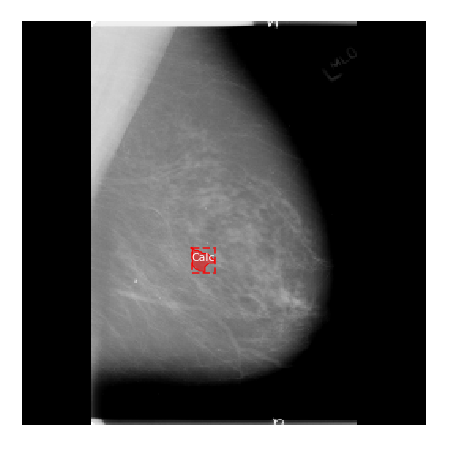

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


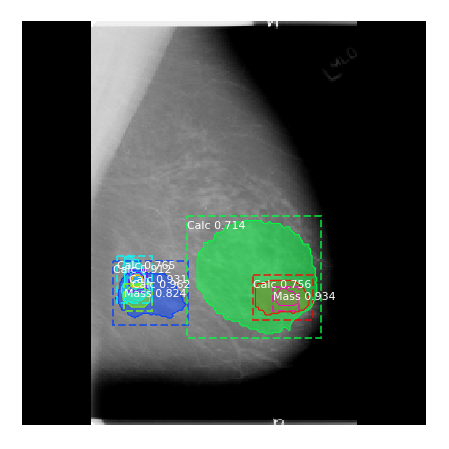

In [21]:
# Test on a random image
# well : 529
# 478
image_id = random.choice(dataset_val.image_ids)

print(image_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))


results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())


241
original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  760.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:   50.00000  max:  211.00000  int32
gt_mask                  shape: (256, 256, 2)         min:    0.00000  max:    1.00000  bool


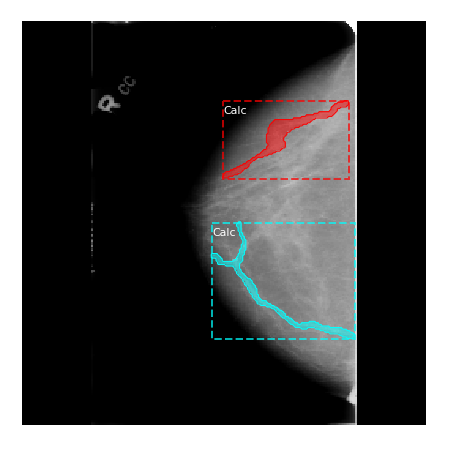

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


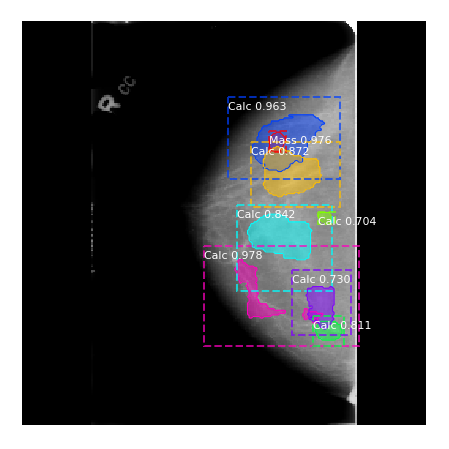

In [20]:
# Test on a random image
# well : 529
# 478
image_id = random.choice(dataset_train.image_ids)

print(image_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))


results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'], ax=get_ax())


In [23]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 100)
APs = []
precisions_list=[]
recalls_list=[]
overlaps_list=[]

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    precisions_list.append(precisions)
    recalls_list.append(recalls)
    overlaps_list.append(overlaps)
    
print("mAP: ", np.mean(APs))

mAP:  0.39236111111111105


In [24]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_train.image_ids, 100)
APs = []
precisions_list=[]
recalls_list=[]
overlaps_list=[]

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_train, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    precisions_list.append(precisions)
    recalls_list.append(recalls)
    overlaps_list.append(overlaps)
    
print("mAP: ", np.mean(APs))

mAP:  0.5283452382442497


In [34]:
precisions_list[0].shape

(6,)

In [46]:
recalls_list[4]

array([0., 1., 1., 1., 1., 1., 1., 1., 1.])

In [40]:
overlaps_list[4]

array([[0.75      ],
       [0.06912182],
       [0.348637  ],
       [0.        ],
       [0.12260128],
       [0.        ],
       [0.        ]], dtype=float32)

In [32]:
a = dataset_train.load_image(5)
a.max()


255

## Test
---

In [50]:
import json
with open(r"E:/DataSet/balloon/val/via_region_data.json", "r") as st_json:
    a = json.load(st_json)
a

{'24631331976_defa3bb61f_k.jpg668058': {'fileref': '',
  'size': 668058,
  'filename': '24631331976_defa3bb61f_k.jpg',
  'base64_img_data': '',
  'file_attributes': {},
  'regions': {'0': {'shape_attributes': {'name': 'polygon',
     'all_points_x': [916,
      913,
      905,
      889,
      868,
      836,
      809,
      792,
      789,
      784,
      777,
      769,
      767,
      777,
      786,
      791,
      769,
      739,
      714,
      678,
      645,
      615,
      595,
      583,
      580,
      584,
      595,
      614,
      645,
      676,
      716,
      769,
      815,
      849,
      875,
      900,
      916,
      916],
     'all_points_y': [515,
      583,
      616,
      656,
      696,
      737,
      753,
      767,
      777,
      785,
      785,
      778,
      768,
      766,
      760,
      755,
      755,
      743,
      728,
      702,
      670,
      629,
      588,
      539,
      500,
      458,
      425,
      394,
      360,
 

In [23]:
import glob
import cv2 as cv

In [35]:
IMG_PATH = r'E:\DataSet\balloon\train\34020010494_e5cb88e1c4_k.jpg'
imgs = glob.glob(IMG_PATH)
x = [ 1020, 1000, 994, 1003, 1023, 1050, 1089, 1134, 1190, 1265, 1321, 1361, 1403, 1428, 1442, 1445, 1441, 1427, 1400, 1361, 1316, 1269, 1228, 1198, 1207, 1210, 1190, 1177, 1172, 1174, 1170, 1153, 1127, 1104, 1061, 1032, 1020 ]
y = [ 963, 899, 841, 787, 738, 700, 663, 638, 621, 619, 643, 672, 720, 765, 800, 860, 896, 942, 990, 1035, 1079, 1112, 1129, 1134, 1144, 1153, 1166, 1166, 1150, 1136, 1129, 1122, 1112, 1084, 1037, 989, 963 ]

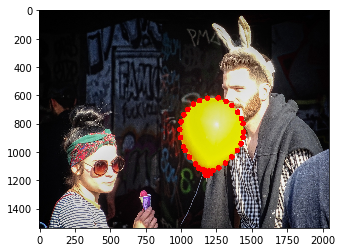

In [36]:
img = plt.imread(imgs[0])

for i in range(len(x)):
    cv.circle(img,(x[i],y[i]),20,(255,0,0),-1)

plt.imshow(img)

In [37]:
IMG_PATH = r'E:\DataSet\balloon\train\25899693952_7c8b8b9edc_k.jpg'
imgs = glob.glob(IMG_PATH)
x = [ 586, 510, 441, 389, 331, 268, 196, 158, 135, 156, 210, 307, 403, 437, 443, 425, 448, 481, 506, 513, 503, 511, 502, 583, 669, 755, 800, 811, 803, 784, 755, 717, 668, 620, 586 ]
y = [ 133, 116, 115, 126, 149, 185, 261, 339, 438, 560, 664, 784, 868, 893, 929, 964, 964, 961, 965, 958, 936, 910, 896, 836, 752, 636, 538, 454, 392, 329, 270, 220, 175, 149, 133 ]

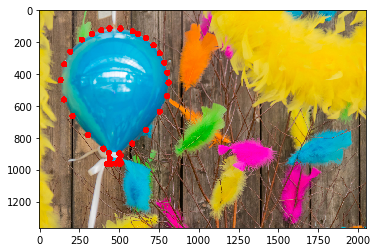

In [38]:
img = plt.imread(imgs[0])

for i in range(len(x)):
    cv.circle(img,(x[i],y[i]),20,(255,0,0),-1)

plt.imshow(img)

In [39]:
IMG_PATH = r'E:\DataSet\balloon\train\605521662_a470fef77f_b.jpg'
imgs = glob.glob(IMG_PATH)

x= [ 400, 424, 450, 444, 456, 470, 488, 485, 473, 449, 423, 391, 361, 342, 341, 356, 373, 400 ]
y= [ 368, 368, 377, 391, 384, 397, 435, 469, 497, 519, 528, 522, 501, 466, 424, 397, 380, 368 ]

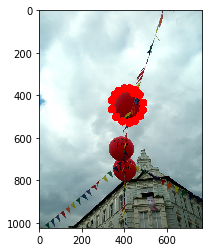

In [40]:
img = plt.imread(imgs[0])

for i in range(len(x)):
    cv.circle(img,(x[i],y[i]),20,(255,0,0),-1)

plt.imshow(img)

In [45]:
IMG_PATH = r'E:\DataSet\balloon\train\351678851_e2aeebdafd_b.jpg'
imgs = glob.glob(IMG_PATH)

x1 = [ 67, 105, 137, 163, 169, 171, 161, 137, 87, 44, 2, 2, 32, 57, 67 ]
y1 = [ 15, 42, 72, 117, 144, 204, 247, 288, 274, 278, 295, 0, 0, 5, 15 ]
x11 = [ 601, 584, 562, 530, 489, 450, 415, 376, 340, 311, 288, 273, 265, 266, 279, 303, 330, 361, 399, 438, 478, 516, 548, 581, 595, 607, 607, 601 ]
y11 = [ 253, 297, 325, 357, 383, 400, 407, 410, 401, 370, 330, 290, 247, 210, 167, 124, 96, 76, 60, 55, 55, 68, 86, 118, 148, 187, 226, 253 ]

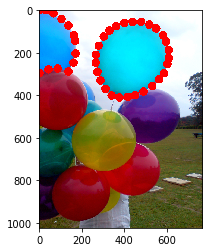

In [46]:
img = plt.imread(imgs[0])

for i in range(len(x1)):
    cv.circle(img,(x1[i],y1[i]),20,(255,0,0),-1)
    
for i in range(len(x11)):
    cv.circle(img,(x11[i],y11[i]),20,(255,0,0),-1)

plt.imshow(img)